# Otimização de Hiperparâmetros

# Importar pacotes

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import linear_model

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV


# Conjunto de dados cana-de-açúcar (Prova): FA084-P1-Dataset-UCR.csv


In [3]:
df = pd.read_csv('FA084-P1-Dataset-UCR.csv')

# Manter as quatro safras com maior número de registros e
# DESCARTAR OS DEMAIS REGISTROS
row_retain = df.safra.value_counts()[:4].index.tolist()
df = df[df.safra.isin(row_retain)]

# Mmanter as três variedades com maior número de registros
# DESCARTAR OS DEMAIS REGISTROS
row_retain = df.variedade.value_counts()[:3].index.tolist()
df = df[df.variedade.isin(row_retain)]

# Trocar '12m', '15M' e '18m' por '1'
df['estagio'] = [1 if ((x == '18m') or (x == '15M') or (x == '12m')) else x for x in df.estagio]

# Converter 'df.estagio' de 'object' para 'integer'
df['estagio'] = df.estagio.astype(int)

# Manterr apenas registros dos cinco primeiros cortes e
# DESCARTAR OS DEMAIS REGISTROS
df = df.drop(df[df['estagio'] >= 6].index)

# Exclusão dos atributos 'Unnamed: 0', 'bloco', 'usina'
att_excl = ['Unnamed: 0', 'bloco', 'usina']
df.drop(att_excl, axis = 1, inplace=True)

# Aplicar One-Hot-Encode em 'variedade' e 'ambProd'
df = pd.get_dummies(df)

# Excluir tchEst e criar Atributos Preditores (X) e Atributo Meta (y)
y = df.tchReal
X = df.drop(['tchReal','tchEst'],axis=1)

# Criar Conjunto de Treino (train) e Teste (test), 70/30, random_state=2020
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 2020, test_size=0.3)

# Normalizar (Z-Score) os atributos preditores numéricos do conjunto de treino e aplicar a transformação no conjunto de teste.

# Normalização do X_train
def_scaler = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(pd.DataFrame(def_scaler.transform(X_train), columns=X_train.columns))

# Realizar mesma transformação em X_test
X_test_norm = pd.DataFrame(def_scaler.transform(X_test), columns=X_train.columns)

In [4]:
# ==> CHECK-POINT <==
# Dimensões do DataFrame após as alterações: (2918, 18)
df.shape

(2918, 18)

In [6]:
# Verificar primeiras linhas do DataFrame
X.head()

,safra,codFaz,talhao,estagio,days,variedade_RB855453,variedade_RB867515,variedade_SP813250,ambProd_A,ambProd_ADEF,ambProd_B,ambProd_C,ambProd_D,ambProd_E,ambProd_F,ambProd_G
0,21213,430001,1,4,412,1,0,0,0,0,1,0,0,0,0,0
1,21213,430001,2,4,412,0,0,1,0,0,1,0,0,0,0,0
2,21213,430001,3,4,407,0,0,1,0,0,1,0,0,0,0,0
3,21213,430001,4,4,402,0,0,1,0,0,1,0,0,0,0,0
10,21213,430001,10,4,412,1,0,0,0,0,1,0,0,0,0,0


In [7]:
# Construção de uma função para otimização dos hiperparâmetros

def rnd_hyper_tunning(model, param, niter):
  rnd_search = RandomizedSearchCV(model, 
                                  param_distributions=param,
                                  n_iter=niter,
                                  cv=5,
                                  random_state=2020)
  rnd_search.fit(X_train_norm, y_train)
  return rnd_search.best_params_

# Construção dos Modelos

## KNN

In [8]:
%%time
# Otimizar hiperparâmetro K

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'n_neighbors':np.arange(1,30,2)})
# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 15

# Chamar a função rnd_hyper_tunning
knn_params = rnd_hyper_tunning(KNeighborsRegressor(), params,niter)
# Mostrar os melhores hiperparâmetros
print("Melhor K", knn_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
knn = KNeighborsRegressor(n_neighbors=knn_params['n_neighbors']).fit(X_train_norm, y_train)
knn_pred = knn.predict(X_test_norm)

knn_mae = mean_absolute_error(y_test,knn_pred)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))

print('mae =',knn_mae, 'rmse =', knn_rmse)

Melhor K {'n_neighbors': 3}
mae = 10.897705479452053 rmse = 19.251295784532577
CPU times: user 2.17 s, sys: 752 µs, total: 2.17 s
Wall time: 2.18 s


Random Forest

In [ ]:
%%time
# Otimizar hiperparâmetros 

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'max_features':np.linspace(0.1, 0.8, 8),
               'n_estimators':np.arange(100,2001,100)})

# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 15

# Chamar a função rnd_hyper_tunning
rf_params = rnd_hyper_tunning(RandomForestRegressor(), params,niter)
# Mostrar os melhores hiperparâmetros
print("Melhores parâmetros:", rf_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
rf = RandomForestRegressor(max_features=rf_params['max_features'],
                           n_estimators=rf_params['n_estimators']).fit(X_train_norm, y_train)
rf_pred = rf.predict(X_test_norm)

rf_mae = mean_absolute_error(y_test,rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print('mae =',rf_mae, 'rmse =', rf_rmse)

## XGB

In [9]:
%%time
# Otimizar hiperparâmetros 

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'max_depth':np.arange(2,10),
               'n_estimators':np.arange(100,2001,100)})

# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 15

# Chamar a função rnd_hyper_tunning
xgb_params = rnd_hyper_tunning(XGBRegressor(objective='reg:squarederror'), params,niter)
# Mostrar os melhores hiperparâmetros
print("Melhores parâmetros:", xgb_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
xgb = XGBRegressor(objective='reg:squarederror',
                   max_depth=xgb_params['max_depth'],                   
                   n_estimators=xgb_params['n_estimators']).fit(X_train_norm, y_train)
xgb_pred = xgb.predict(X_test_norm)

xgb_mae = mean_absolute_error(y_test,xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print('mae =',xgb_mae, 'rmse =', xgb_rmse)

Melhores parâmetros: {'n_estimators': 100, 'max_depth': 7}
mae = 9.700020305511615 rmse = 17.71841926663448
CPU times: user 2min 4s, sys: 981 ms, total: 2min 5s
Wall time: 2min 6s


## SVM (SVR)

In [ ]:
%%time
# Otimizar hiperparâmetros 

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'gamma':np.arange(1e-2,1e+2,1e-1),
               'C':np.arange(1e-3,1e3,1e-3)})

# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 50

# Chamar a função rnd_hyper_tunning
svm_params = rnd_hyper_tunning(SVR(kernel='rbf'), params,niter)
# Mostrar os melhores hiperparâmetros
print("Melhores parâmetros:", svm_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
svm = SVR(kernel='rbf',
          gamma=svm_params['gamma'],
          C=svm_params['C']).fit(X_train_norm, y_train)
svm_pred = svm.predict(X_test_norm)

svm_mae = mean_absolute_error(y_test,svm_pred)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_pred))

print('mae =',svm_mae, 'rmse =', svm_rmse)

## Regressão Linear Múltipla (PURA)

In [11]:
%%time
# Criar modelo, ajust-a-lo ao conjunto de treino, 
# fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)

rlm_reg = LinearRegression()

rlm = rlm_reg.fit(X_train_norm, y_train)
rlm_pred = rlm.predict(X_test_norm)

rlm_mae = mean_absolute_error(y_test,rlm_pred)
rlm_rmse = np.sqrt(mean_squared_error(y_test, rlm_pred))

print('mae =',rlm_mae, 'rmse =', rlm_rmse)

mae = 17.938787630831868 rmse = 24.04835976093142
CPU times: user 8.65 ms, sys: 13 ms, total: 21.6 ms
Wall time: 43.6 ms


## LASSO

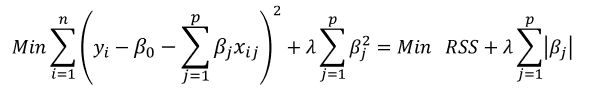

In [12]:
%%time
# Otimizar hiperparâmetros 

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'alpha':np.arange(1e-3,1e+3,1e-3)})

# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 200

# Chamar a função rnd_hyper_tunning
lasso_params = rnd_hyper_tunning(Lasso(), params, niter)
# Mostrar os melhores hiperparâmetros
print("Melhores parâmetros:", lasso_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
lasso = Lasso(alpha=lasso_params['alpha']).fit(X_train_norm, y_train)

lasso_pred = lasso.predict(X_test_norm)

lasso_mae = mean_absolute_error(y_test,lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

print('mae =',lasso_mae, 'rmse =', lasso_rmse)


Melhores parâmetros: {'alpha': 0.871}
mae = 18.276048847823333 rmse = 24.242750948722183
CPU times: user 6.09 s, sys: 4.27 s, total: 10.4 s
Wall time: 5.29 s


## RIDGE

In [13]:
%%time
# Otimizar hiperparâmetros 

# Definir os parâmetros (dicionário) que se pretende otimizar
params = dict({'alpha':np.arange(1e-3,1e+3,1e-3)})

# Definir o número de vezes que vai rodar combinando os hiperparâmetros conforme definido acima
niter = 200

# Chamar a função rnd_hyper_tunning
ridge_params = rnd_hyper_tunning(Ridge(), params, niter)
# Mostrar os melhores hiperparâmetros
print("Melhores parâmetros:", ridge_params)

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
ridge = Ridge(alpha=lasso_params['alpha']).fit(X_train_norm, y_train)

ridge_pred = ridge.predict(X_test_norm)

ridge_mae = mean_absolute_error(y_test,ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

print('mae =',ridge_mae, 'rmse =', ridge_rmse)


Melhores parâmetros: {'alpha': 120.54400000000001}
mae = 17.92959876379083 rmse = 24.001646187766273
CPU times: user 5.91 s, sys: 4.13 s, total: 10 s
Wall time: 5.13 s


## LASSOCV

In [14]:
%%time

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
reg_lassoCV = LassoCV().fit(X_train_norm,y_train)

reg_lassoCV_pred = reg_lassoCV.predict(X_test_norm)

reg_lassoCV_mae = mean_absolute_error(y_test,reg_lassoCV_pred)
reg_lassoCV_rmse = np.sqrt(mean_squared_error(y_test, reg_lassoCV_pred))

print('mae =',reg_lassoCV_mae, 'rmse =', reg_lassoCV_rmse)


mae = 17.985557961437127 rmse = 24.019696353889433
CPU times: user 118 ms, sys: 78.9 ms, total: 197 ms
Wall time: 113 ms


RIDGECV

In [15]:
%%time

# Ajustar modelo ao conjunto de treino, fazer a predição no conjunto de teste e avaliar resultado (MAE e RMSE)
reg_ridgeCV = RidgeCV().fit(X_train_norm,y_train)


reg_ridgeCV_pred = reg_ridgeCV.predict(X_test_norm)

reg_ridgeCV_mae = mean_absolute_error(y_test,reg_ridgeCV_pred)
reg_ridgeCV_rmse = np.sqrt(mean_squared_error(y_test, reg_ridgeCV_pred))

print('mae =',reg_ridgeCV_mae, 'rmse =', reg_ridgeCV_rmse)


mae = 17.93251770570341 rmse = 24.002603916167917
CPU times: user 8.5 ms, sys: 5.91 ms, total: 14.4 ms
Wall time: 10.5 ms


In [16]:
reg_lassoCV.coef_

array([ 1.96576151, -1.33879193, -2.44290912, -7.08481734,  0.        ,
        5.04417301,  0.        , -3.59190448,  0.55028131,  0.06376334,
        2.49782113,  1.80716432, -1.27939842,  0.        , -1.93890501,
       -4.99169833])